In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, optimize, fft, interpolate

In [470]:
raw_data = []
for i in range(10):
    dat =  pd.read_csv("csv_samples/{}.csv".format(i+3), names=["c","t", "U"], skiprows=8)
    raw_data.append(np.asarray(dat["U"]))
    
raw_data = np.asarray(raw_data)

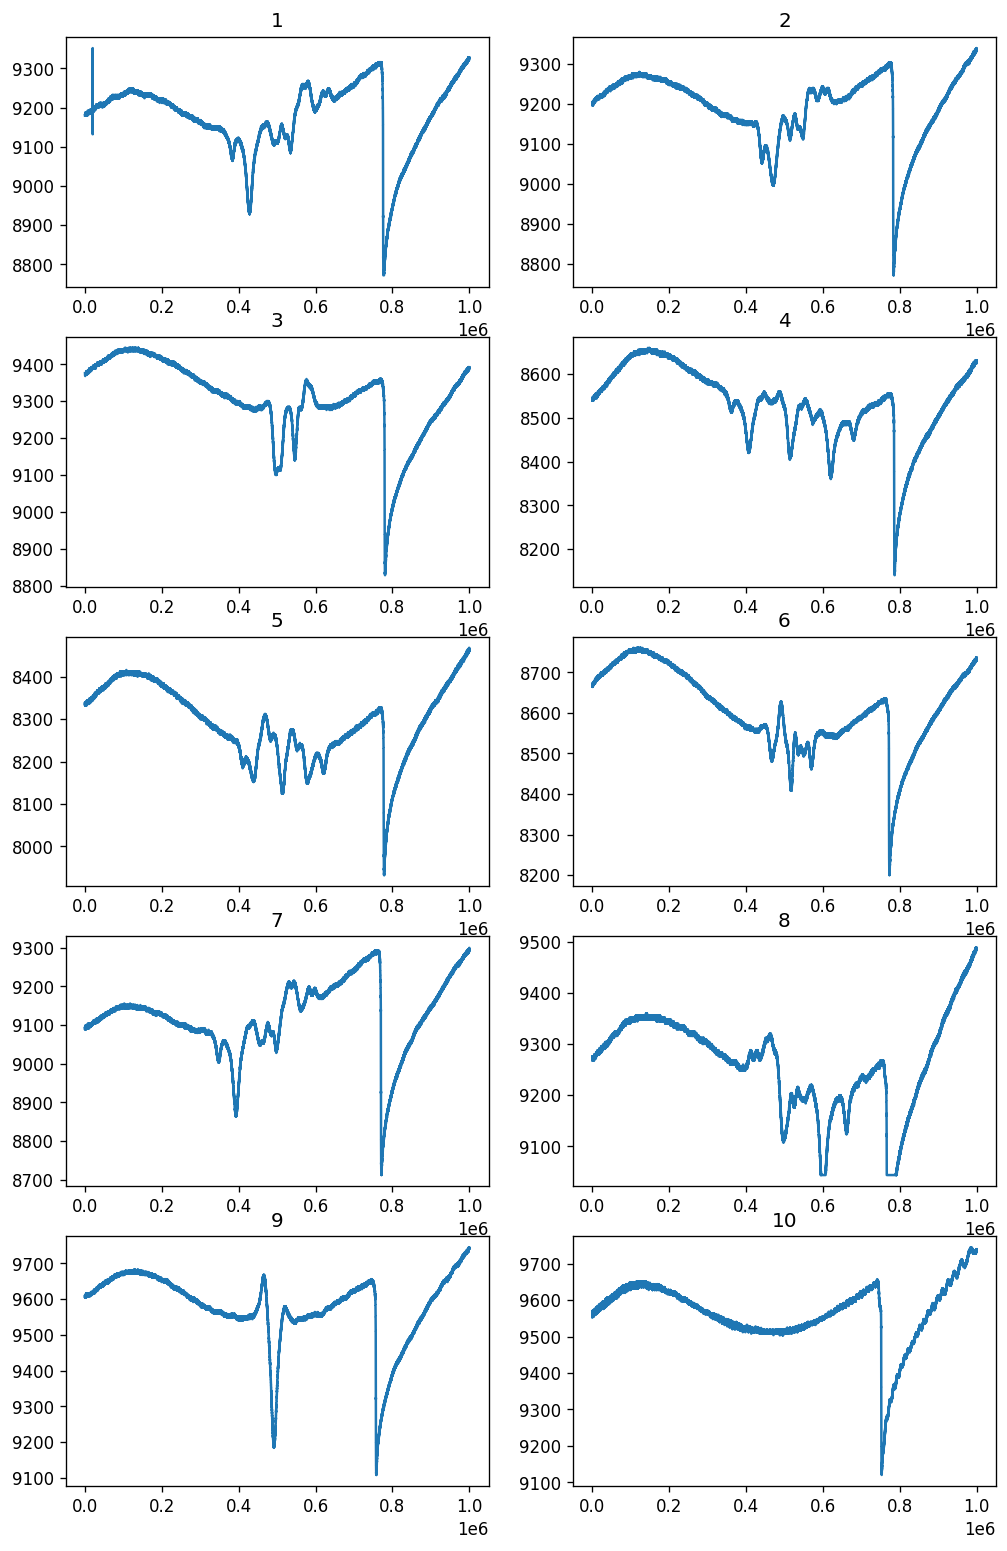

In [471]:
plt.figure(figsize=(10,16), dpi=120)
for i, dat in zip(range(1,11), raw_data):
    plt.subplot(5, 2, i)
    plt.plot(dat)
    plt.title(str(i))

In [472]:
fix_ind = [raw_data[i].argmin() for i in range(10)]
fix_ind[7] = raw_data[7][700000:].argmin() + 700000
delta1, delta2 = (-600000, -20000)

In [473]:
semifinal_data = [dat[ind+delta1:ind+delta2] for dat, ind in zip(raw_data, fix_ind)]
# data1 = [semifinal_data[i] - semifinal_data[-1] for i in range(len(semifinal_data)-1)]
data = []
for i in range(len(semifinal_data) - 1):
    dat = semifinal_data[i] - semifinal_data[-1]
    dat = dat - np.mean(dat)
    dat = dat / np.abs(dat).max()
    data.append(dat)

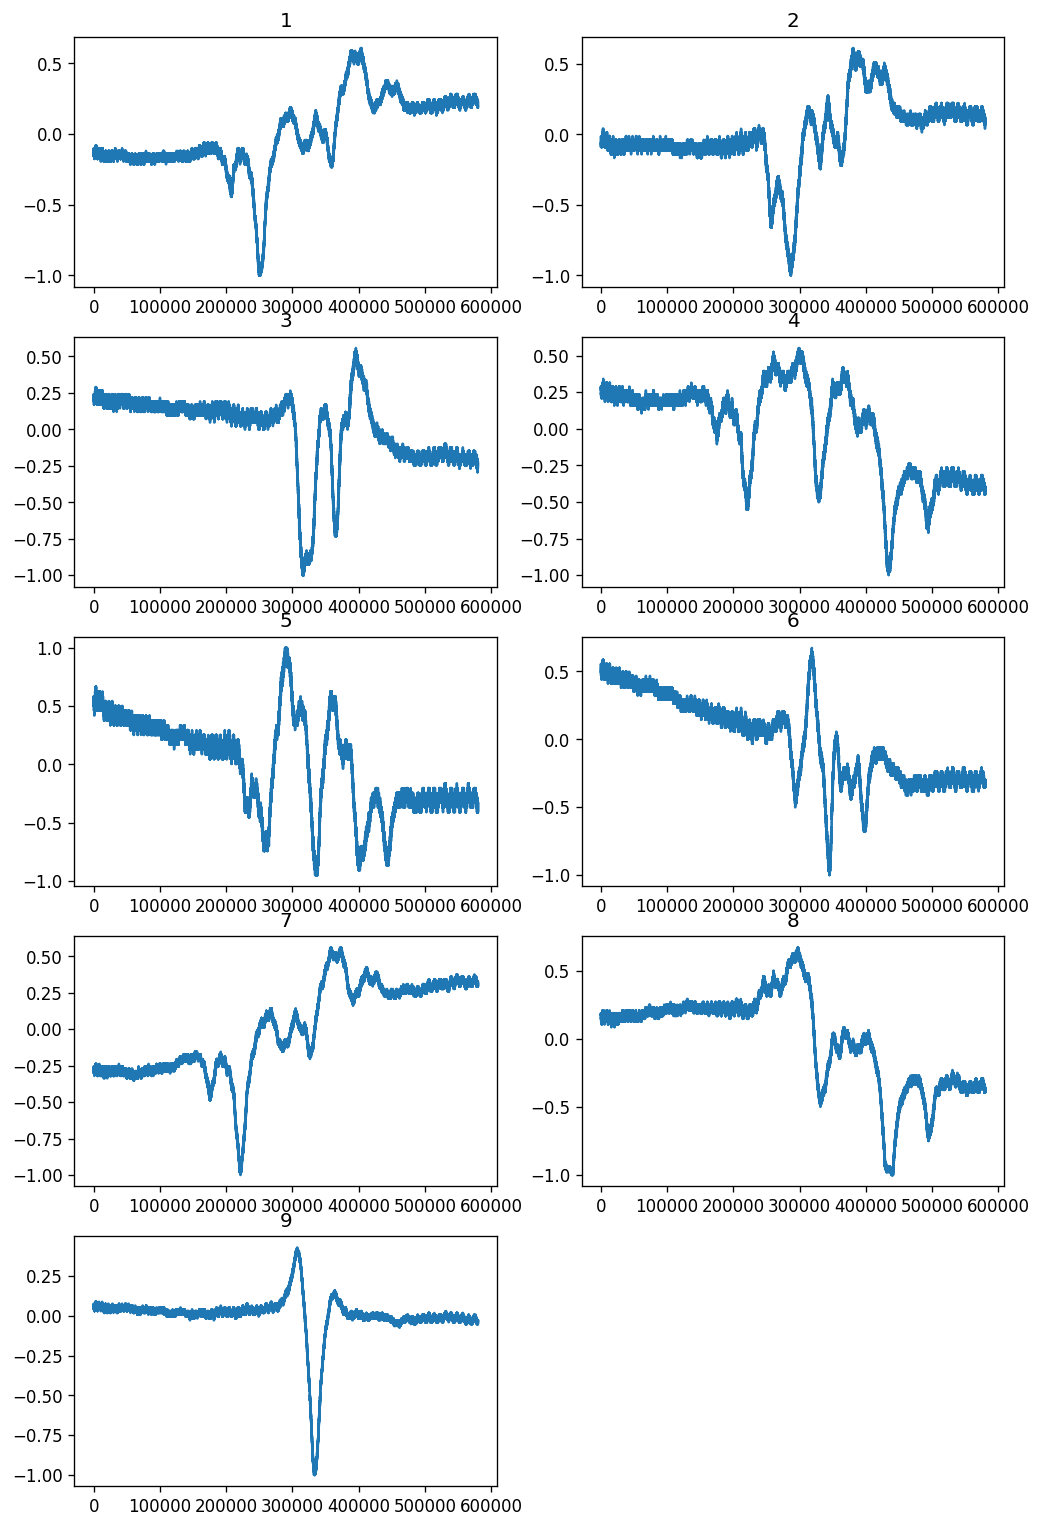

In [474]:
plt.figure(figsize=(10,16), dpi=120)
for i, dat in zip(range(1,len(data)+1), data):
    plt.subplot(5, 2, i)
    plt.plot(dat)
    plt.title(str(i))

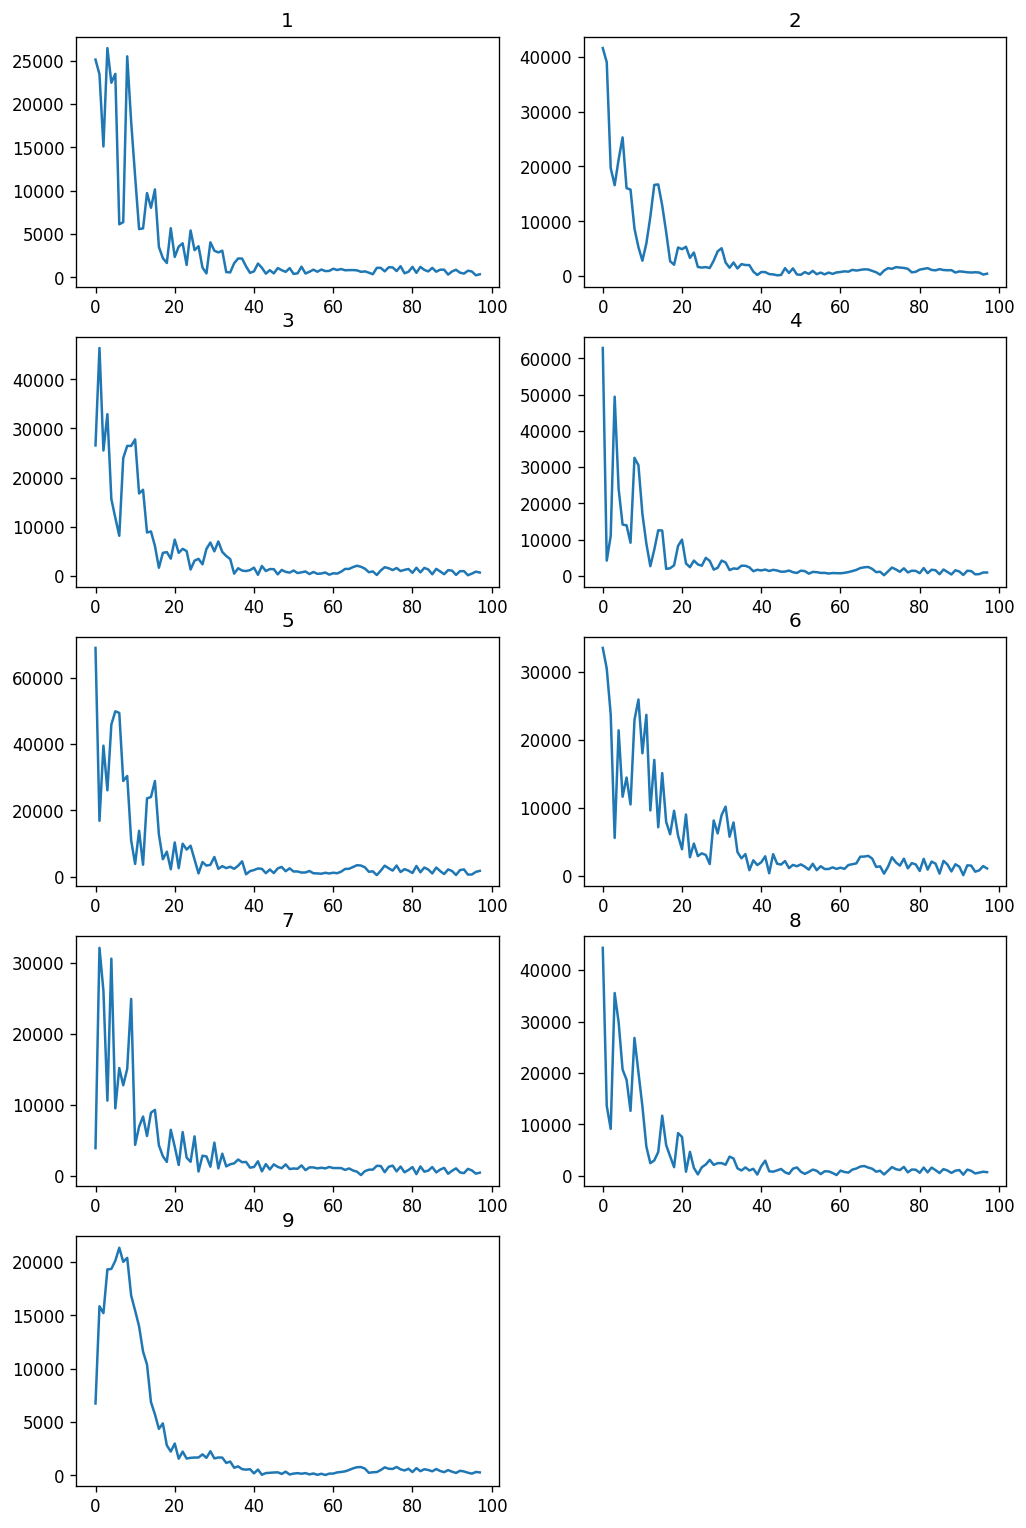

In [475]:
plt.figure(figsize=(10,16), dpi=120)
for i, dat in zip(range(1,len(data)+1), data):
    plt.subplot(5, 2, i)
    plt.plot(np.abs(fft.rfft(dat)[2:100]))
    plt.title(str(i))

In [476]:
w = 20
N = data[0].shape[0]
window = int(N / 4 / w * 1.2)
wnd = -np.ones(window * 3)
wnd[window+1 : 2*window+1] = 2
wnd = wnd / 3 / window

In [477]:
convolutions = []
for dat in data:
    # single convolution
    cnv = signal.convolve(dat, wnd, mode='same')
    cnv[:int(1.5 * window)] = 0
    cnv[-int(1.5 * window):] = 0
    cnv = cnv/ np.abs(cnv).max()
    cnv = signal.convolve(cnv, wnd, mode='same')
    cnv[:int(1.5 * window)] = 0
    cnv[-int(1.5 * window):] = 0
    cnv = cnv/ np.abs(cnv).max()
    convolutions.append(cnv)

convolutions = np.asarray(convolutions)

In [478]:
def get_pikes(sygnal, cut=0.05, pike_width=3000):
    smpl = np.copy(sygnal)
    smpl[smpl<= cut] = 0
    pks, *_ = signal.argrelmax(smpl)
    pkds = pks[1:] - pks[:-1]
    stops = pks[np.concatenate((pkds, [pike_width+1])) > pike_width]
    starts = pks[np.concatenate(([pike_width+1], pkds)) > pike_width]
    pks2 = []
    for strt,stp in zip(starts, stops):
        pkc = int((strt+stp)/2)
        lowm = np.argmin(smpl[strt - pike_width : pkc]) + strt - pike_width
        lowp = np.argmin(smpl[pkc : stp + pike_width]) + pkc
        # maxim = np.argmax(smpl[lowm:lowp]) + lowm
        try:
            popt, *_ = optimize.curve_fit(lambda x, a, b, c: a*(x-b)**2 + c, np.arange(lowm, lowp), smpl[lowm : lowp], p0=[1e-3, pkc, 1])
        except RuntimeError:
            plt.subplot(211)
            plt.plot(sygnal[lowm:lowp])
            plt.subplot(212)
            plt.plot(sygnal)
        maxim = popt[1]
        pks2.append(maxim)

    pks2 = np.asarray(pks2)
    return pks2

In [479]:
pikes = [get_pikes(cnv, pike_width=3000) for cnv in convolutions]

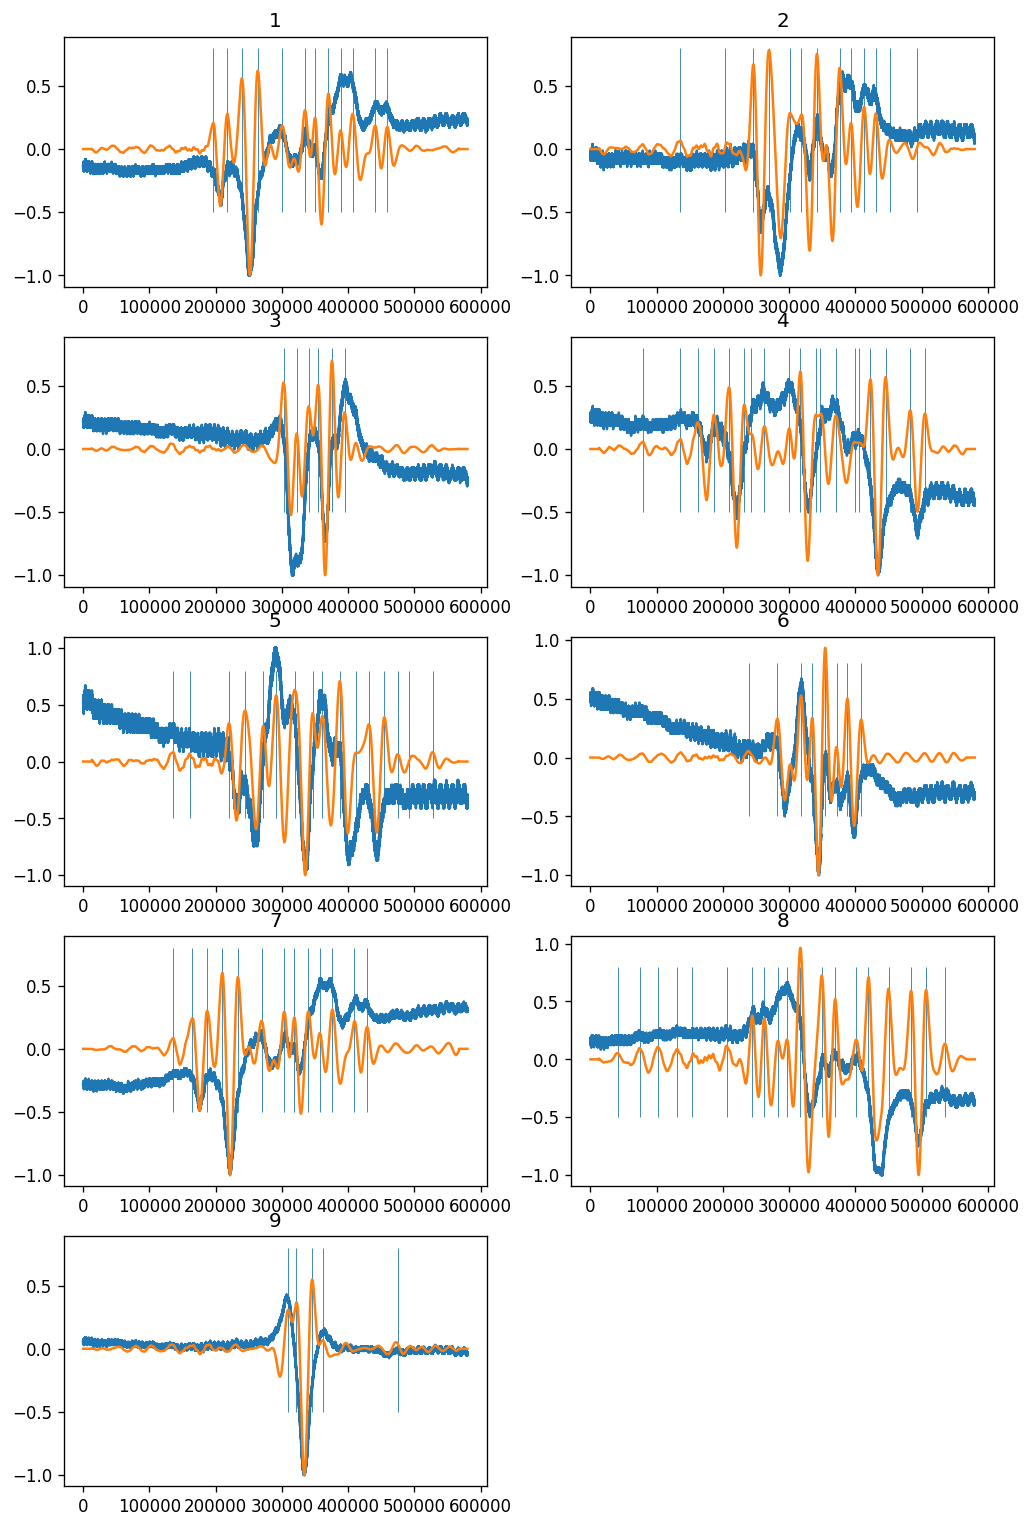

In [495]:
plt.figure(figsize=(10,16), dpi=120)
for i, dat, cnv, pks in zip(range(1,len(data)+1), data, convolutions, pikes):
    plt.subplot(5, 2, i)
    plt.plot(dat)
    plt.plot(cnv)
    plt.vlines(pks, -0.5, 0.8, lw=0.5)
    plt.title(str(i))

Выбирать пички придется ручками исходя из теории, частично.

In [481]:
# read Zeeman levels
Zeeman_levels_data_S = pd.read_csv("External/2S12 Level Data.dat", names=["B"]+["S1/2.{}".format(i+1) for i in range(6)])
Zeeman_levels_data_P = pd.read_csv("External/2P12 Level Data.dat", names=["B"]+["P1/2.{}".format(i+1) for i in range(6)])
Zeeman_levels_data_P3 = pd.read_csv("External/2P32 Level Data.dat", names=["B"]+["P3/2.{}".format(i+1) for i in range(12)])
B_S = np.asarray(Zeeman_levels_data_S["B"])
S_levels = np.asarray([np.asarray(Zeeman_levels_data_S["S1/2.{}".format(i+1)]) for i in range(6)])
B_P = np.asarray(Zeeman_levels_data_P["B"])
P_levels = np.asarray([np.asarray(Zeeman_levels_data_P["P1/2.{}".format(i+1)]) for i in range(6)])
B_P3 = np.asarray(Zeeman_levels_data_P["B"])
P3_levels = np.asarray([np.asarray(Zeeman_levels_data_P3["P3/2.{}".format(i+1)]) for i in range(12)])
processed_S = False
processed_P = False
processed_P3 = False

In [482]:
if not processed_S:
    S_levels[[1, 2],109:] = S_levels[[2, 1],109:]
    S_levels[[2, 3, 4, 5]] = S_levels[[5, 4, 3, 2]]
    processed_S = True

if not processed_P:
    P_levels[[1, 2], 38:] = P_levels[[2, 1], 38:]
    P_levels[[1, 2, 3, 4, 5]] = P_levels[[2, 5, 4, 3, 1]]
    processed_P = True
    
if not processed_P3:
    P3_levels[[0, 1], 22:156] = P3_levels[[1, 0], 22:156]
    P3_levels[[4, 5], 1] = P3_levels[[5, 4], 1]
    P3_levels[[1, 3], 0] = P3_levels[[3, 1], 0]
    P3_levels[[8, 7], :7] = P3_levels[[7, 8], :7]
    P3_levels[[6, 7], 3:] = P3_levels[[7, 6], 3:]
    P3_levels[[3, 5], 1:4] = P3_levels[[5, 3], 1:4]
    P3_levels[[3, 7], 4:] = P3_levels[[7, 3], 4:]
    P3_levels[[5, 7], 1:4] = P3_levels[[7, 5], 1:4]
    P3_levels[[8, 11], 0] = P3_levels[[11, 8], 0]
    P3_levels[[5, 10], 1] = P3_levels[[10, 5], 1]
    P3_levels[[11, 10], 1] = P3_levels[[10, 11], 1]
    P3_levels[[10, 9], 1] = P3_levels[[9, 10], 1]
    P3_levels[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]] = P3_levels[[1, 2, 4, 6, 9, 10, 11, 8, 3, 5, 7, 0]]
    processed_P3 = True

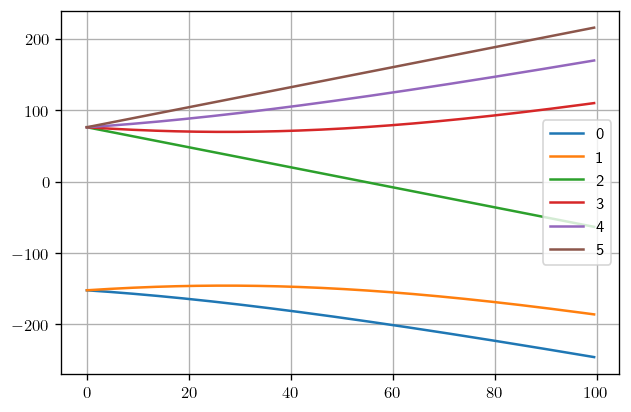

In [612]:
plt.figure(dpi=120)
m, n = (0, 200)
for i in range(0,6):
    plt.plot(B_S[m:n], S_levels[i][m:n], label="{}".format(i))
    # plt.plot(B_P[m:n], P_levels[i, m:n], label="{}".format(i))
    # plt.plot(B_P3[m:n], P3_levels[i, m:n], label="{}".format(i))

plt.legend(loc="best")
plt.grid(True)
plt.show()

In [581]:
def shortest_dist(pikes, levels1, levels2):
    '''
    Calculate minimal possible error across set of pikes for transition from
    levels1 to levels2
    '''
    dist = []
    l1, l2 = np.ix_(levels1, levels2)
    transitions = np.ravel(l2-l1)
    for pk in pikes:
        dist.append(np.abs(transitions - pk).min())
        
    return np.array(dist)

In [615]:
spl_S = [interpolate.UnivariateSpline(B_S, s_line, s=0) for s_line in S_levels]
spl_P = [interpolate.UnivariateSpline(B_P, p_line, s=0) for p_line in P_levels]
spl_P3 = [interpolate.UnivariateSpline(B_P3, p3_line, s=0) for p3_line in P3_levels]

def D1_dist(B, pikes):
    if B < 0:
        return 1e7
    l1 = np.array([spls(B) for spls in spl_S]).reshape((-1))
    l2 = np.array([splp(B) for splp in spl_P]).reshape((-1))
    return shortest_dist(pikes, l1, l2)

def D2_dist(B, pikes):
    if B < 0:
        return 1e7
    l1 = np.array([spls(B) for spls in spl_S]).reshape((-1))
    l2 = np.array([splp(B) for splp in spl_P3]).reshape((-1))
    return shortest_dist(pikes, l1, l2)

def D1_dist_shift(vec, pikes):
    B = vec[0]
    sht = vec[1]
    tmp_pikes = pikes - sht
    return D1_dist(B, tmp_pikes)

def D1_dist_shift_scale(vec, pikes):
    B = vec[0]
    sht = vec[1]
    scl = vec[2]
    tmp_pikes = scl * (pikes - sht)
    return D1_dist(B, tmp_pikes) * (1+(4-4*scl)**4)

def D2_dist_shift(vec, pikes):
    B = vec[0]
    sht = vec[1]
    tmp_pikes = pikes - sht
    return D2_dist(B, tmp_pikes)

def D2_dist_shift_scale(vec, pikes):
    B = vec[0]
    sht = vec[1]
    scl = vec[2]
    tmp_pikes = scl * (pikes - sht)
    return D2_dist(B, tmp_pikes) * (1+(4-4*scl)**4)
    
def get_pikesD1(B):
    l1 = np.array([spls(B) for spls in spl_S]).reshape((-1))
    l2 = np.array([splp(B) for splp in spl_P]).reshape((-1))
    l11, l22 = np.ix_(l1, l2)
    return np.ravel(l22 - l11)

def get_pikesD2(B):
    l1 = np.array([spls(B) for spls in spl_S]).reshape((-1))
    l2 = np.array([splp(B) for splp in spl_P3]).reshape((-1))
    l11, l22 = np.ix_(l1, l2)
    return np.ravel(l22 - l11)

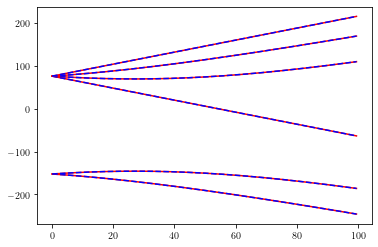

In [616]:
for i in range(6):
    plt.plot(B_S[m:n], spl_S[i](B_S[m:n]),'r-', label="{}".format(i))
    plt.plot(B_S[m:n], S_levels[i][m:n], 'b--', label="{}".format(i))

Проградуируемся. Для этого поставим в соотвествие осциллограме без поля картину линий сверхтонкого расщепления.

In [669]:
hf_l1 = np.array([S_levels[0, 0], S_levels[4, 0]])
hf_l2 = np.array([(P_levels[0, 0] + P_levels[4, 0])/2])
hf_l = hf_l2 - hf_l1
hf_lines = pikes[8][[0, 3]]
scale = np.abs(hf_lines[1] - hf_lines[0]) / np.abs(hf_l[1] - hf_l[0])
# pk_w = (pk - shift)/scale
shift = hf_lines.max() - scale*hf_l.max()

In [670]:
scale, shift

(227.94653519597577, 328028.9800249909)

In [671]:
l1, l2 = np.ix_(hf_l1, hf_l22)
hf_true_l = np.ravel(l2 - l1)

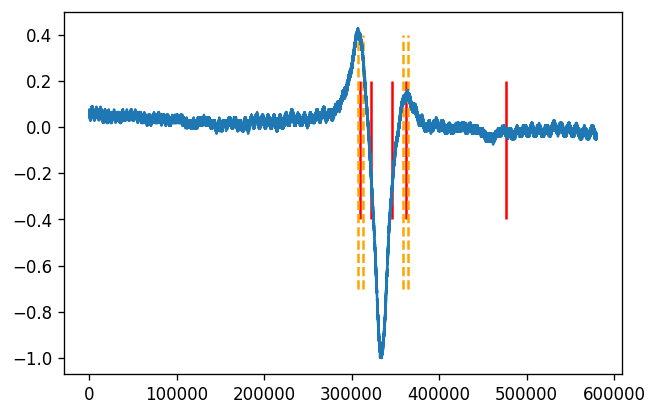

In [672]:
plt.figure(dpi=120)
plt.plot(data[8])
plt.vlines(pikes[8], -0.4, 0.2, colors="r")
plt.vlines(hf_true_l*scale + shift, -0.7, 0.4, linestyles="dashed", colors="orange")
plt.show()

In [673]:
scale, shift

(227.94653519597577, 328028.9800249909)

Окей, возьмем какой-нибудь красивый графичек, например 4

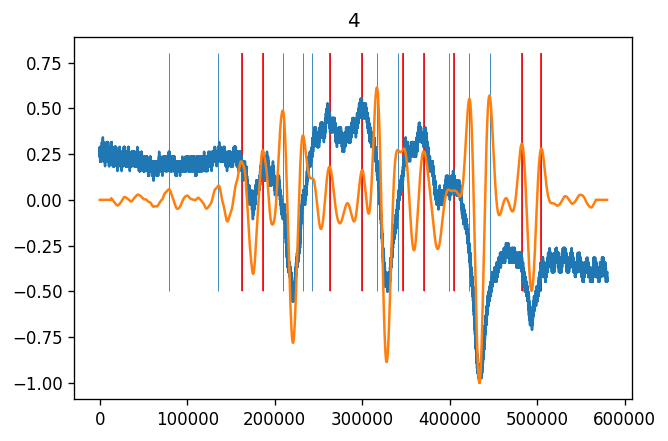

In [527]:
plt.figure(dpi=120)
plt.plot(data[3])
# plt.plot(data[8])
# plt.plot(data[5])
plt.plot(convolutions[3])
plt.vlines(pikes[3], -0.5, 0.8, lw=0.5)
plt.vlines(true_pikes_4, -0.5, 0.8, lw=1, colors="red")
plt.title(str(4))
plt.show()

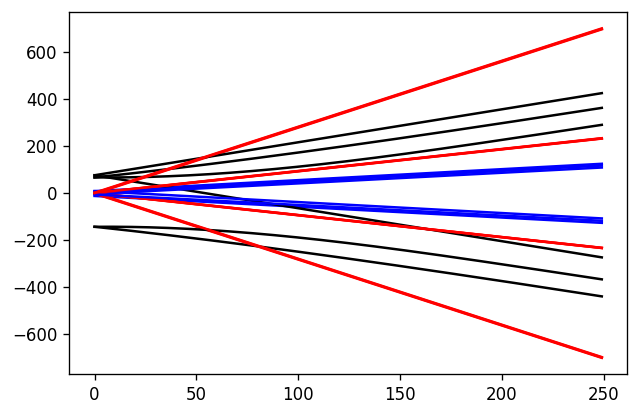

In [444]:
bs = np.arange(250)
plt.figure(dpi=120)
for i in range(6):
    plt.plot(bs, spl_S[i](bs), 'k')
    plt.plot(bs, spl_P[i](bs), 'b')
    plt.plot(bs, spl_P3[2*i](bs), 'r')
    plt.plot(bs, spl_P3[2*i+1](bs), 'r')

In [509]:
true_pikes_4 = pikes[3][[2,3,7,8,11,12,14,17,18]]
scaled_pikes_4 = (true_pikes_4 - shift) / scale

In [542]:
popt, cov = optimize.leastsq(D1_dist_shift, [200, 0], args=(scaled_pikes_4))
B4 = popt[0]
sht4 = popt[1]
print(B4, sht4)

320.0659398518711 1.8820630724002345


In [540]:
estimated_pikes_4 = get_pikesD1(B4) + sht4

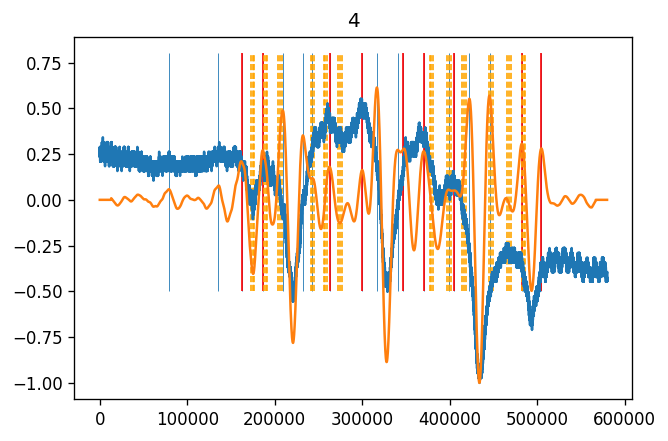

In [541]:
plt.figure(dpi=120)
plt.plot(data[3])
plt.plot(convolutions[3])
plt.vlines(pikes[3], -0.5, 0.8, lw=0.5)
plt.vlines(true_pikes_4, -0.5, 0.8, lw=1, colors="red")
plt.vlines(estimated_pikes_4*scale + shift, -0.5, 0.8, lw=1, colors="orange", linestyle="dashed")
plt.title(str(4))
plt.show()

In [546]:
popt, cov = optimize.leastsq(D2_dist, [200], args=(scaled_pikes_4))
B4 = popt[0]
# sht4 = popt[1]
print(B4)

194.6121232275738


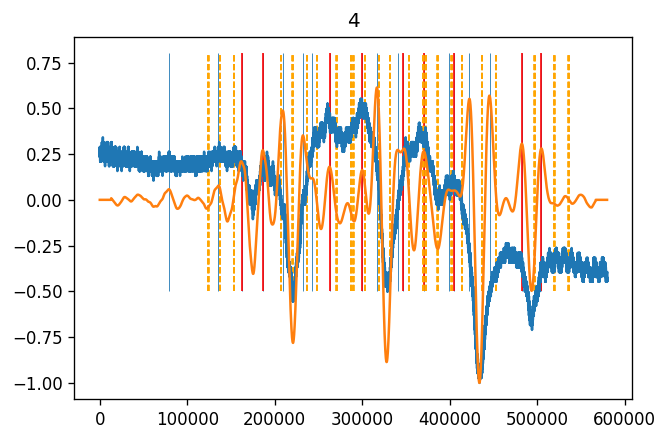

In [547]:
estimated_pikes_4 = get_pikesD2(B4) 
plt.figure(dpi=120)
plt.plot(data[3])
plt.plot(convolutions[3])
plt.vlines(pikes[3], -0.5, 0.8, lw=0.5)
plt.vlines(true_pikes_4, -0.5, 0.8, lw=1, colors="red")
plt.vlines(estimated_pikes_4*scale + shift, -0.5, 0.8, lw=1, colors="orange", linestyle="dashed")
plt.title(str(4))
plt.show()

Посмотрим на 5 картинку

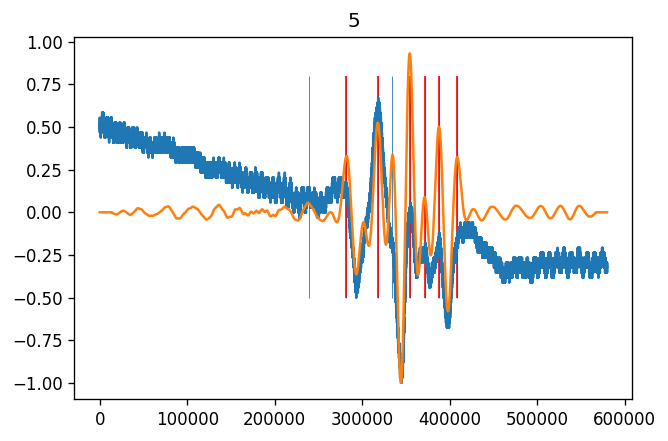

In [433]:
plt.figure(dpi=120)
plt.plot(data[5])
plt.plot(convolutions[5])
plt.vlines(pikes[5], -0.5, 0.8, lw=0.5)
plt.vlines(true_pikes_5, -0.5, 0.8, lw=1, colors="red")
plt.title(str(5))
plt.show()

In [434]:
true_pikes_5 = pikes[5][[1, 2, 4, 5, 6, 7]]
scaled_pikes_5 = (true_pikes_5 - shift) / scale

In [524]:
popt, cov = optimize.leastsq(D1_dist, [0], args=(scaled_pikes_5))
B4 = popt[0]
print(B4)

116.9269781042108


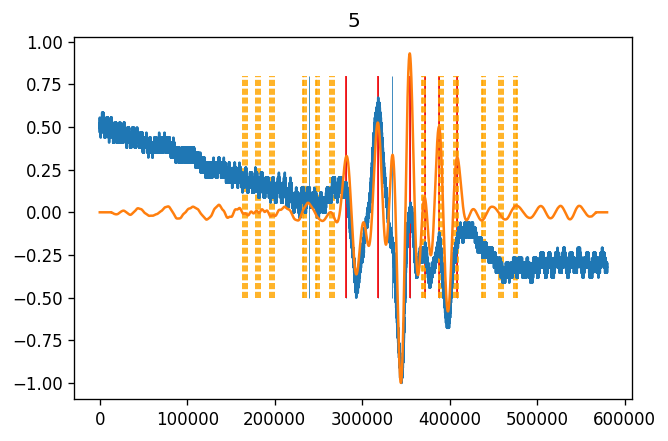

In [525]:
estimated_pikes_5 = get_pikesD1(B4) - sht5
plt.figure(dpi=120)
plt.plot(data[5])
plt.plot(convolutions[5])
plt.vlines(pikes[5], -0.5, 0.8, lw=0.5)
plt.vlines(true_pikes_5, -0.5, 0.8, lw=1, colors="red")
plt.vlines(estimated_pikes_5*scale + shift, -0.5, 0.8, lw=1, colors="orange", linestyle="dashed")
plt.title(str(5))
plt.show()

In [526]:
popt, cov = optimize.leastsq(D2_dist, [0], args=(scaled_pikes_5))
B4 = popt[0]
print(B4)

49.31436740444995


In [ ]:
estimated_pikes_5 = get_pikesD2(B4) - sht5
plt.figure(dpi=120)
plt.plot(data[5])
plt.plot(convolutions[5])
plt.vlines(pikes[5], -0.5, 0.8, lw=0.5)
plt.vlines(true_pikes_5, -0.5, 0.8, lw=1, colors="red")
plt.vlines(estimated_pikes_5*scale + shift, -0.5, 0.8, lw=1, colors="orange", linestyle="dashed")
plt.title(str(5))
plt.show()

In [447]:
hf_l1 = np.array([S_levels[0, 0], S_levels[4, 0]])
hf_l2 = np.array([(P3_levels[0, 0] + P3_levels[11, 0])/2])
hf_l = hf_l2 - hf_l1
hf_lines = pikes[8][[0, 3]]
scale2 = np.abs(hf_lines[1] - hf_lines[0]) / np.abs(hf_l[1] - hf_l[0])
# pk_w = (pk - shift)/scale
shift2 = hf_lines.max() - scale*hf_l.max()

In [448]:
l1, l2 = np.ix_(hf_l1, hf_l22)
hf_true_l = np.ravel(l2 - l1)

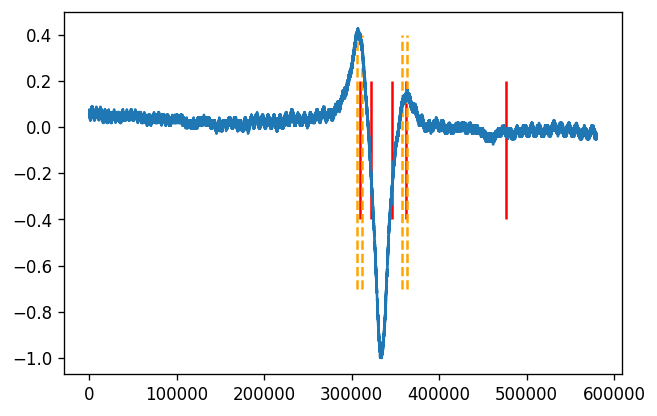

In [449]:
plt.figure(dpi=120)
plt.plot(data[8])
plt.vlines(pikes[8], -0.4, 0.2, colors="r")
plt.vlines(hf_true_l*scale + shift, -0.7, 0.4, linestyles="dashed", colors="orange")
plt.show()

In [456]:
shift2-shift, scale2-scale, shift # пофиг пофиг

(-1120.4373197667883, 0.0, 328028.9800249909)

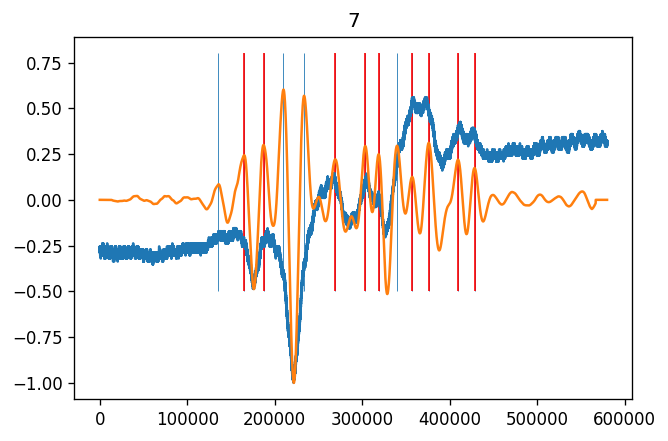

In [674]:
plt.figure(dpi=120)
plt.plot(data[6])
plt.plot(convolutions[6])
plt.vlines(pikes[6], -0.5, 0.8, lw=0.5)
plt.vlines(true_pikes_7, -0.5, 0.8, lw=1, colors="red")
plt.title(str(7))
plt.show()

In [675]:
true_pikes_7 = pikes[6][[1, 2, 5, 6, 7, 9, 10, 11, 12]]
scaled_pikes_7 = (true_pikes_7 - shift) / scale
popt, cov = optimize.leastsq(D2_dist_shift_scale, [100, 0, 1], args=(scaled_pikes_7))
B7 = popt[0]
cov7 = cov
sht7 = popt[1]
scl7 = popt[2]
print(B7, sht7, scl7)
poptD1, covD1 = optimize.leastsq(D1_dist_shift, [100, 0, 1], args=(scaled_pikes_7))
B71 = poptD1[0]
sht71 = poptD1[1]
#cl71 = poptD1[2]
print(B71, sht71)
# sht5 = popt[1]
# sB5 = np.sqrt(cov)

128.23010500276143 -33.63766159206429 0.9558831358811504
237.5583396052246 -165.63651038092274


In [676]:
scaled_pikes_7[1:] - scaled_pikes_7[:-1]

array([100.56156285, 358.62101217, 150.16280844,  66.82180812,
       168.12156339,  83.94929967, 146.14033245,  83.3846256 ])

In [677]:
scaled_pikes_7.max() - scaled_pikes_7.min()

1157.763012694617

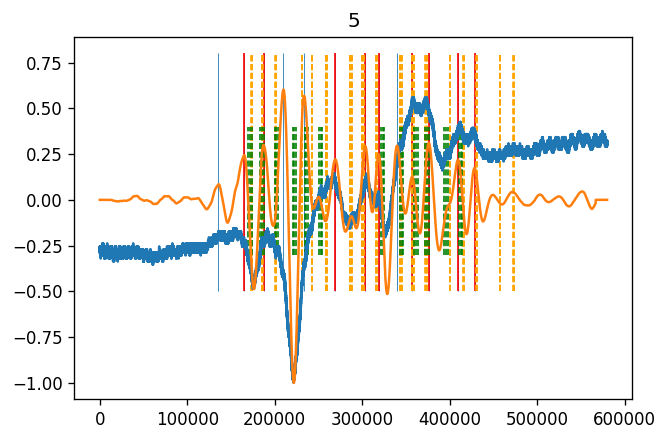

In [678]:
estimated_pikes_7 = get_pikesD2(B7) / scl7 + sht7
estimated_pikes_71 = get_pikesD1(B71) + sht71
plt.figure(dpi=120)
plt.plot(data[6])
plt.plot(convolutions[6])
plt.vlines(pikes[6], -0.5, 0.8, lw=0.5)
plt.vlines(true_pikes_7, -0.5, 0.8, lw=1, colors="red")
plt.vlines(estimated_pikes_7*scale + shift, -0.5, 0.8, lw=1, colors="orange", linestyle="dashed")
plt.vlines(estimated_pikes_71*scale + shift, -0.3, 0.4, lw=1, colors="green", linestyle="dashed")
plt.title(str(5))
plt.show()

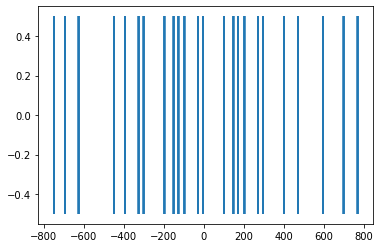

In [599]:
plt.vlines(get_pikesD2(160), -0.5, 0.5)

Some tests for numbers of sync convolution

In [77]:
t1 = np.arange(5)
t2 = np.arange(3)
tt1, tt2 = np.ix_(t1, t2)
np.ravel(tt1-tt2)

array([ 0, -1, -2,  1,  0, -1,  2,  1,  0,  3,  2,  1,  4,  3,  2])

In [13]:
w1 = 20
w2 = 30
N = test_smpl.shape[0]
window1 = int(N / 4 / w1 * 1.2)
window2 = int(N / 4 / w2 * 1.2)
wnd1 = -np.ones(window1 * 3)
wnd1[window1+1 : 2*window1+1] = 2
wnd1 = wnd1 / 3 / window1
wnd2 = -np.ones(window2 * 3)
wnd2[window2+1 : 2*window2+1] = 2
wnd2 = wnd2 / 3 / window2

NameError: name 'test_smpl' is not defined

In [ ]:
test_smpl = data[5]
test_smpl = test_smpl - np.mean(test_smpl)
test_smpl = test_smpl / np.abs(test_smpl).max()

cnvs = []
cnv = test_smpl
for i in range(5):
    cnv = signal.convolve(cnv, wnd1, mode='same')
    cnv[:int(1.5 * window1)] = 0
    cnv[-int(1.5 * window1):] = 0
    cnv = cnv/ np.abs(cnv).max()
    cnvs.append(cnv)

cnv1 = signal.convolve(test_smpl, wnd1, mode='same')
cnv1[:int(1.5 * window1)] = 0
cnv1[-int(1.5 * window1):] = 0
cnv1 = cnv1/ np.abs(cnv1).max()
cnv2 = signal.convolve(test_smpl, wnd2, mode='same')
cnv2[:int(1.5 * window2)] = 0
cnv2[-int(1.5 * window2):] = 0
cnv2 = cnv2/ np.abs(cnv2).max()
cnv22 = signal.convolve(cnv2, wnd2, mode='same')
cnv22[:int(1.5 * window2)] = 0
cnv22[-int(1.5 * window2):] = 0
cnv22 = cnv22/ np.abs(cnv22).max()

In [ ]:
a,b = (260000, 430000)
plt.figure(dpi=120)
plt.plot(test_smpl[a:b])

plt.plot(cnv1[a:b])
plt.plot(cnv2[a:b])
plt.plot(cnv22[a:b])
# for i in range(5):
 #   plt.plot(cnvs[i][a:b])

Короче, судя по всему, стоит делать максимум вторую свертку, чем и займемся.

In [602]:
plt.rcParams["text.usetex"] = True

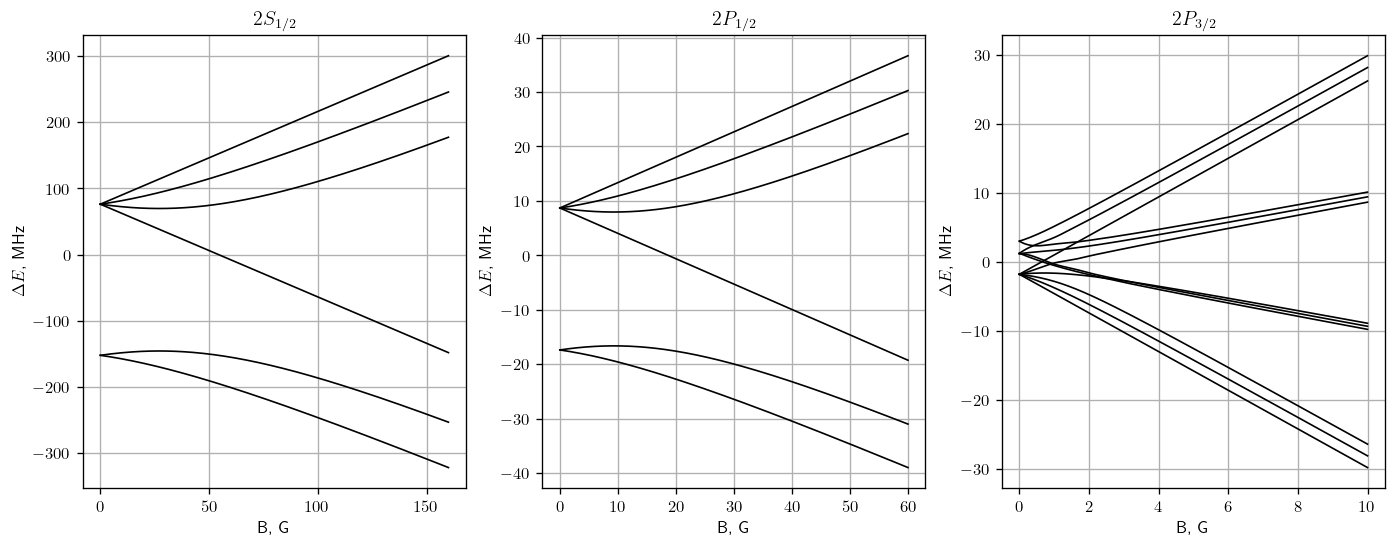

In [621]:
plt.figure(figsize=(14, 5), dpi=120)

b_s = np.linspace(0, 160, 200)
b_p = np.linspace(0, 60, 200)
b_p3 = np.linspace(0, 10, 200)

plt.subplot(131)
for spl in spl_S:
    plt.plot(b_s, spl(b_s), 'k-', lw=1)
plt.grid(True)
plt.title(r"$2S_{1/2}$")
plt.xlabel(r"B, G")
plt.ylabel(r"$\Delta E$, MHz")

plt.subplot(132)
for spl in spl_P:
    plt.plot(b_p, spl(b_p), 'k-', lw=1)
plt.grid(True)
plt.title(r"$2P_{1/2}$")
plt.xlabel(r"B, G")
plt.ylabel(r"$\Delta E$, MHz")

plt.subplot(133)
for spl in spl_P3:
    plt.plot(b_p3, spl(b_p3), 'k-', lw=1)
plt.grid(True)
plt.title(r"$2P_{3/2}$")
plt.xlabel(r"B, G")
plt.ylabel(r"$\Delta E$, MHz")
plt.savefig("plt1.pdf")

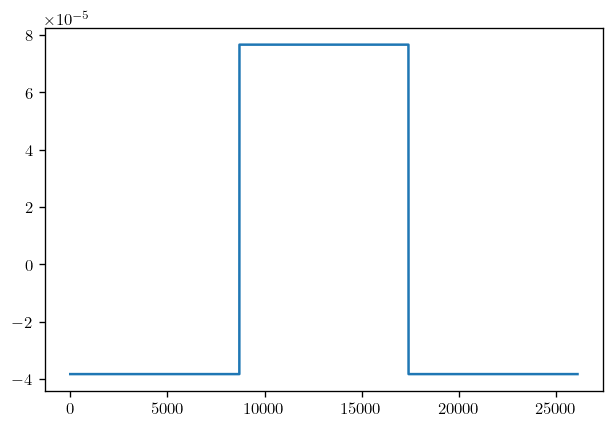

In [624]:
plt.figure(dpi=120)
plt.plot(wnd)
plt.savefig("wnd.pdf")

In [628]:
plt.rcParams['text.usetex'] = False

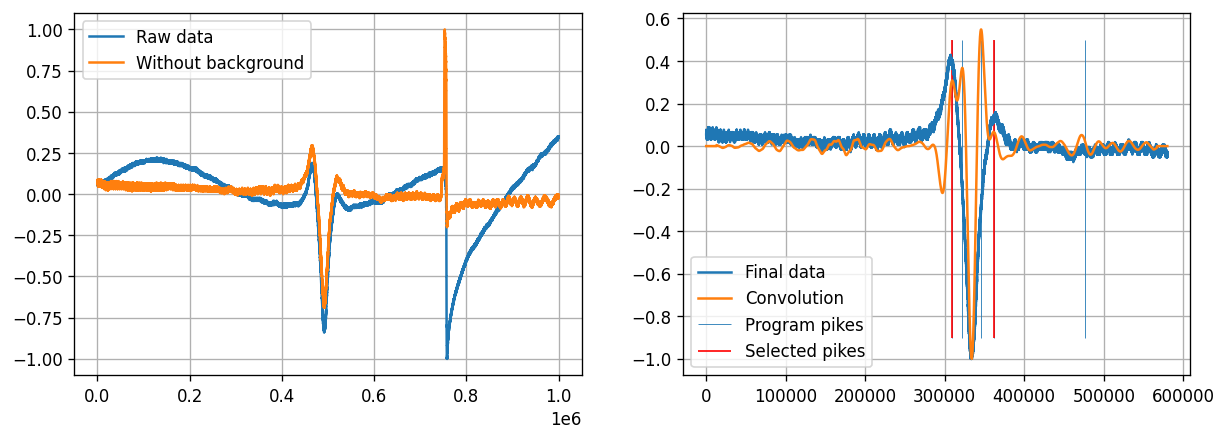

In [643]:
plt.figure(figsize=(12, 4), dpi=120)
plt.subplot(121)
plt.plot((raw_data[-2] - np.mean(raw_data[-2]))/np.abs(raw_data[-2] - np.mean(raw_data[-2])).max(), label="Raw data")
tmp = raw_data[-2] - raw_data[-1]
tmp = tmp - np.mean(tmp)
plt.plot(tmp/np.abs(tmp).max(), label="Without background")
plt.grid(True)
plt.legend(loc='best')
plt.subplot(122)
plt.plot(data[-1], label="Final data")
plt.plot(convolutions[-1], label="Convolution")
plt.vlines(pikes[-1], -0.9, 0.5, lw=0.5, label="Program pikes")
plt.vlines(pikes[-1][[0,3]], -0.9, 0.5, lw=1, colors="red", label="Selected pikes")
plt.grid(True)
plt.legend(loc='lower left')
plt.savefig("exsmpl.pdf")

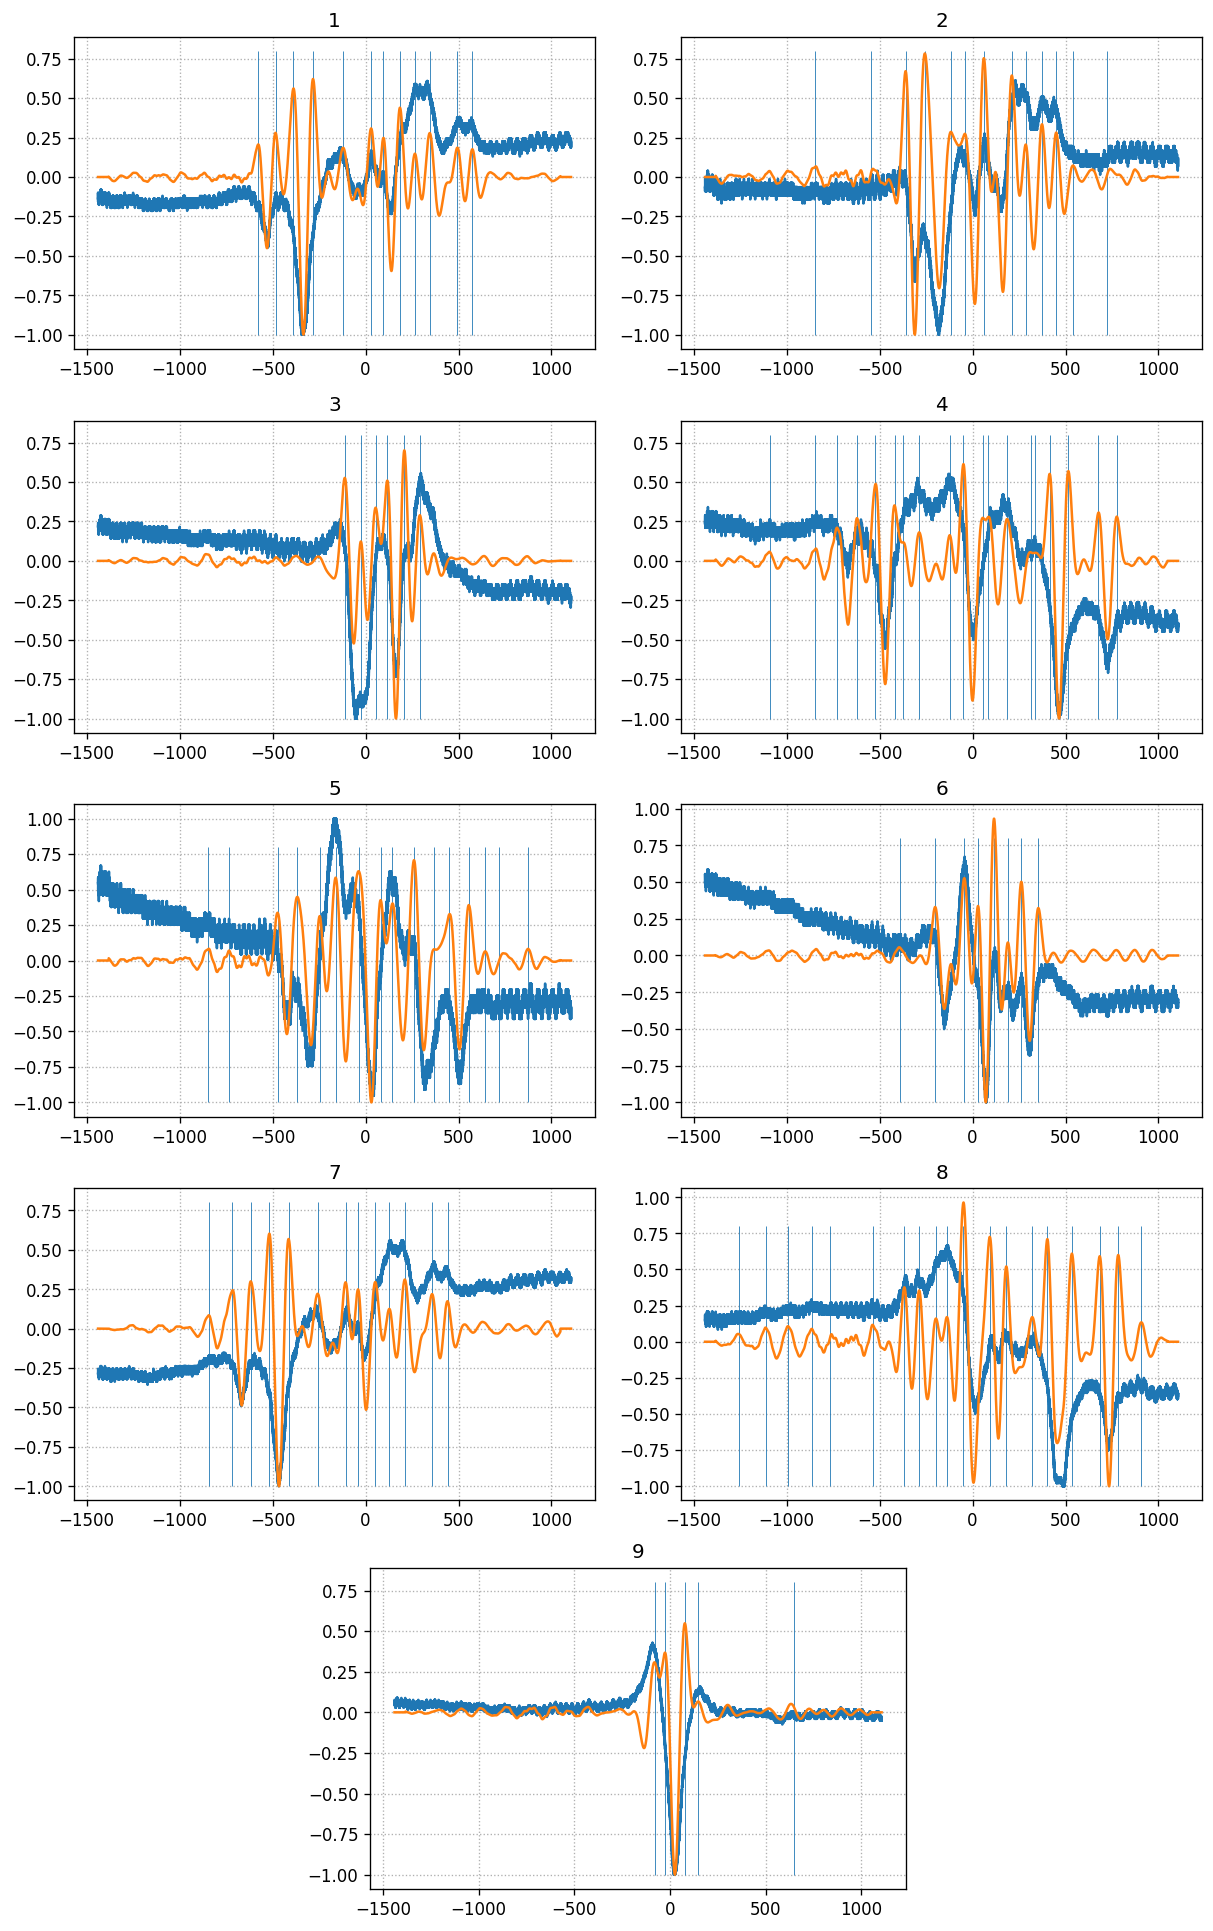

In [656]:
deltaE = (np.arange(data[0].shape[0]) - shift) / scale
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10,16), dpi=120, constrained_layout=True)

gs = GridSpec(5, 2, figure=fig)
ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i, 0]))
    ax.append(fig.add_subplot(gs[i, 1]))
ax.append(fig.add_subplot(gs[4,:]))


for i, dat, cnv, pks, axis in zip(range(1,len(data)+1), data, convolutions, pikes, ax):
    axis.set_box_aspect(0.6)
    axis.grid(True)
    axis.grid(which='major', linestyle = ':')
    axis.grid(which='minor', linestyle = ':')
    axis.plot(deltaE, dat)
    axis.plot(deltaE, cnv)
    axis.vlines((pks - shift)/scale, -1, 0.8, lw=0.5)
    axis.set_title(str(i))
plt.savefig("samples.pdf")

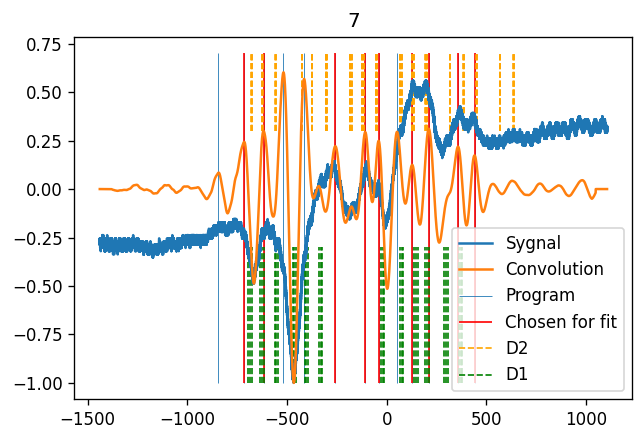

In [679]:
estimated_pikes_7 = get_pikesD2(B7) / scl7 + sht7
estimated_pikes_71 = get_pikesD1(B71) + sht71
plt.figure(dpi=120)
plt.plot(deltaE, data[6], label="Sygnal")
plt.plot(deltaE, convolutions[6], label="Convolution")
plt.vlines((pikes[6]- shift)/scale, -1, 0.7, lw=0.5, label="Program")
plt.vlines((true_pikes_7- shift)/scale, -1, 0.7, lw=1, colors="red", label="Chosen for fit")
plt.vlines(estimated_pikes_7, 0.3, 0.7, lw=1, colors="orange", linestyle="dashed", label="D2")
plt.vlines(estimated_pikes_71, -1, -0.3, lw=1, colors="green", linestyle="dashed", label="D1")
plt.title(str(7))
plt.legend(loc="best")
plt.savefig("seven.pdf")

In [668]:
B7

128.23010500276143

In [681]:
cov7

1